In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import itertools
from scipy.optimize import root
from scipy.special import comb

Each spatiotemporal solution to the KSE is a scalar spatiotemporal velocity field $u(t,x)$ which satisfies the equation

#### Spatiotemporal Henon 

$$F_n(\phi_n) = -\phi_{n+1}+a\phi^{2}_n + b\phi_{n-1} -1 = 0$$

#### Parameter values

$a = 6\\
b = -1$

#### Explicit examples of shifted states

Using dummy values for completely demonstrative purposes, 

If 
$\phi_n = [1, 2, 3, 4, 5]$

Then

$\phi_{n-1} = [5, 1, 2, 3, 4] \\
\phi_{n+1} = [2, 3, 4, 5, 1]$

#### 

The approach of this notebook is to simply solve the equation, hopefully in a variational manner spatiotemporally.



# Single Cycle Implementation

We will produce initial conditions using shadow states; mapping symbolic configurations of equilibria into numerical
arrays.

The Henon map can be written as a 2-step recursive equation 

$$x_{n+1} =  -1 + a x_n^2 + b x_{n-1}$$

This is included so that we can see if the cycle can be approximately reproduced by iterating a single point N times.

In [351]:
def iterate(xn, xn_minus_1, a, b):
    return -1 + a * xn **2 + b * xn_minus_1, xn


$$F_n(\phi) = -\phi_{n+1}+a\phi^{2}_n + b\phi_{n-1} -1 = \mathbf{0}$$

In [49]:
def eqn(state, a, b):
    return -np.roll(state, -1) + a * state**2 + b * np.roll(state, 1) - 1

# Optimization routines

Before any special custom implementation, it will almost always benefit us to see if we can use premade solvers to give
us something that is "good enough", as it saves a tremendous amount of time and effort. 

# scipy.optimize.root

This function attempts to solve $F(\phi) = 0$ as a root solving problem; as this is a vector equation, our function that we pass needs to return the entire vector of F values. This function, `root` takes 1. the function we want roots of, 2. the initial condition/guess, 3. any addition arguments passed to the variable `args` as a tuple.

In [354]:
state = np.array([0.607, 0.607])
result = root(eqn, state, args=(a, b))

xn_minus_1, xn = result.x
example_trajectory=  [xn_minus_1, xn]
for i in range(20):
    print(f'Iteration number {i} had discrepancy between iterations equal to {xn-xn_minus_1}')
    xn, xn_minus_1 = iterate(xn, xn_minus_1, a, b)
    example_trajectory.append(xn)


In [361]:
negative_fixed_point = np.array([-0.274, -0.274])
nfp_result = root(eqn, negative_fixed_point, args=(a, b))

xn_minus_1, xn = nfp_result.x
example_trajectory=  [xn_minus_1, xn]
for i in range(25):
    print(f'Iteration number {i} had discrepancy between iterations equal to {xn-xn_minus_1}')
    xn, xn_minus_1 = iterate(xn, xn_minus_1, a, b)
    example_trajectory.append(xn)


Hard coded equilibria values determine from past runs of the previous fixed point searches above

In [ ]:
def generate_states(symbols, n):
    shadow_states = np.concatenate([coord.ravel().reshape(-1, 1) for coord in np.meshgrid(*(shadow_symbols for i in
                                                                                          range(n)))],
                                 axis=1)
    return shadow_states

def _rotate(a):
    x = a[len(a) - 1]
    for i in range(len(a) - 1, 0, -1):
        a[i] = a[i - 1]
    a[0] = x
    return a

def _check_cyclic(cycle_1, cycle_2):
    """ Checks if two cycles are members of the same group cycle

    """
    return ', '.join(map(str, cycle_1)) in ', '.join(map(str, cycle_2))

def prime_cycles(states, check_neg=False, check_rev=False):
    initial_conditions = states.copy()
    double_cycles = np.append(initial_conditions, initial_conditions, axis=1)
    # double_cycles is each shadow state repeated so that it is twice its length. This is used show checking for cyclic
    # permutations as every permunation exists in the cycle as if it goes through it twice. Ex: all cyclic permutation of 01
    # exist somwhere in 0101
    i = 0
    while i < np.shape(initial_conditions)[0]:  # looping through each row of the initial conditions
        j = np.shape(initial_conditions)[0] - 1
        while j > i:  # looping rows of double_cycles, starting at the bottomw and ending before the row of the current
            # cycle we are checking
            if _check_cyclic(initial_conditions[i], double_cycles[j]) == True:
                initial_conditions = np.delete(initial_conditions, j, 0)
                double_cycles = np.delete(double_cycles, j,
                                          0)  # if a cycle string exists in the double_cycle of of another
            j = j - 1  # cycle, delete one of the cycles
        i = i + 1
        
    copy_of_reversed_initial = initial_conditions.copy()
    i = 0
    del_array = np.zeros(np.shape(initial_conditions)[0])
    while i < np.shape(initial_conditions)[0]:
        j = 1
        while j <= np.shape(initial_conditions)[1] - 1:
            _rotate(copy_of_reversed_initial[i])
            if _check_cyclic(copy_of_reversed_initial[i], initial_conditions[i]) == True:
                del_array[i] = 1
            j = j + 1
        i = i + 1

    initial_conditions = np.delete(initial_conditions, np.where(del_array == 1), 0)
    states = initial_conditions
    return states

def shadow_states_mapping(symbol_state):
    shadow_states_dict = {0: -0.27429188517743175, 1: 0.6076252185107651}
    mapped_state = np.array([shadow_states_dict[symbol] for symbol in symbol_state])
    return mapped_state

def n_prime_cycles(n, k):
    if n == 1:
        return k
    elif n == 2:
        return int(comb(k, 2))
    else:
        return int((1./n) * (k ** n - np.sum([n_prime_cycles(j, k) * j for j in range(1, n//2 + 1) if n % j == 0])))

In [408]:
shadow_symbols = [0, 1]
shadow_states_dict = {0: -0.27429188517743175, 1: 0.6076252185107651}

In [474]:
print('Checking that prime states code gives correct number of prime states')
for cycle_length in range(1, 12):
    all_states = generate_states(shadow_symbols, cycle_length)
    prime_states = prime_cycles(all_states)
    print(cycle_length, prime_states.shape[0], prime_states.shape[0] == n_prime_cycles(cycle_length, 2))

Checking that prime states code gives correct number of prime states
1 2 True
2 1 True
3 2 True
4 3 True
5 6 True
6 9 True
7 18 True
8 30 True
9 56 True
10 99 True
11 186 True


In [406]:
xn_minus_1, xn = results_list[0].x[0], results_list[0].x[1]
example_trajectory =  [xn_minus_1, xn]
for i in range(len(results_list[0].x)-2):
    xn, xn_minus_1 = iterate(xn, xn_minus_1, a, b)
    print(i, xn-results_list[0].x[i+2])
    example_trajectory.append(xn)

0 -1.1102230246251565e-16
1 3.3306690738754696e-16
2 -1.1102230246251565e-15
3 3.219646771412954e-15
4 -9.547918011776346e-15
5 2.808864252301646e-14
6 -8.304468224196171e-14
7 2.4513724383723456e-13
8 -7.238654120556021e-13
9 2.1374013670083514e-12
10 -6.31139585038909e-12


In [256]:
results_list = []
for each_initial_condition in prime_states:
    mapped_initial_condition = shadow_states_mapping(each_initial_condition)
    result = root(eqn, mapped_initial_condition, args=(a, b))
    results_list.append(result)
    convergence_statuses = set([result.status for result in results_list])
    assert convergence_statuses == {1}

# Code which converges all prime cycles

The biggest bottleneck is determining the set of prime orbits. 

In [468]:
all_results = []

min_cycle_length = 2
max_cycle_length = 17
for cycle_length in range(min_cycle_length, max_cycle_length + 1):
    t0 = time.time()
    all_states = generate_states(shadow_symbols, cycle_length)
    symbol_chunks = [np.where(all_states.sum(axis=1) == total) for total in range(1, cycle_length)]
    results_list = []
    n_cycles_cumulative = 0
    for each_chunk in symbol_chunks:
        prime_states = prime_cycles(all_states[each_chunk[0]])
        for each_initial_condition in prime_states:
            mapped_initial_condition = shadow_states_mapping(each_initial_condition)
            result = root(eqn, mapped_initial_condition, args=(a, b))
            results_list.append(result)
    convergence_statuses = set([result.status for result in results_list])
    assert convergence_statuses == {1} and (len(results_list) == n_prime_cycles(cycle_length, 2))
    all_results.append(results_list)    
    t1 = time.time()
    print(cycle_length, t1-t0)

2 0.0019979476928710938
3 0.002002239227294922
4 0.0019986629486083984
5 0.0019996166229248047
6 0.005000114440917969
7 0.008999347686767578
8 0.020998477935791016
9 0.05200028419494629
10 0.14200115203857422
11 0.4349985122680664
12 1.4000020027160645
13 4.973998069763184
14 18.598000049591064
15 66.30899977684021
16 261.9443643093109
17 1024.993240594864


In [469]:
all_cycles = np.concatenate(all_results)

In [470]:
all_x = []
all_y = []
for i in range(len(all_cycles[0].x)-1):
    x = [result.x[i] for result in all_cycles]
    y = [result.x[i+1] for result in all_cycles]
    all_x.append(x)
    all_y.append(y)
    

In [471]:
x = np.concatenate((all_x))

In [472]:
y = np.concatenate((all_y))

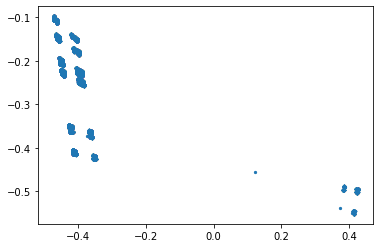

In [473]:
plt.scatter(x, y, s=5)